In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy import ndimage
from func import *
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

In [5]:
def flux_blr(Hb1_blr_br_data,Hb2_blr_br_data,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = np.sum(Hb1_blr_br_data)*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = np.sum(Hb2_blr_br_data)*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)*(10**(-16))
    else:
        flux = flux1*(10**(-16)) 
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum


def energetics(vel_off,Hb_wing_lum,n_e,d_outflow):   
    print vel_off,Hb_wing_lum,n_e,d_outflow
    E_kin_outflow_rate = (100.0/n_e)*(Hb_wing_lum/(10**41))*np.power(vel_off/100.0,3)*(1000.0/d_outflow) # in terms of 10**40 erg/s
    M_outflow_rate = (100.0/n_e)*(Hb_wing_lum/(10**41))*(vel_off/100.0)*(1000.0/d_outflow) # in terms of 3M_s/ year where M_s = Solar Mass
    P_outflow_rate = M_outflow_rate*vel_off #multiplied by 3M_s/year
    return E_kin_outflow_rate,M_outflow_rate,P_outflow_rate

    
def ratio_offset_vel_line_shape(vel_offset,vel_sigma_OIII_br):
    ratio = (vel_offset/vel_sigma_OIII_br)
    return ratio

def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
    plt.plot(wave[select],norm_sum[select],'-k')
    plt.xlim([wav_min+85,wav_max-85])
    plt.show()
    
    select =  (norm_sum>0.05) & (norm_sum<0.5)
    v5_spec = wave[select][0]-wave[select][-1]
    plt.plot(wave[select],norm_sum[select],'-b')
    plt.xlim([wav_min,wav_max])
    plt.show()
    
    [w80,v5] = [((w80_spec)/5006.8)*(c/(1+z)),((v5_spec)/5006.8)*(c/(1+z))]
    return w80,v5


def blr_sigma(obj,z,wo_wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2):
    c = 300000
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    m_0 = np.sum(double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))
    m_1 = np.sum(wo_wave[select]*double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))/m_0
    m_2 = np.sqrt(np.sum(double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)*(wo_wave[select]-m_1)**2)/m_0)
    sigma_Hb_blr = c*(m_2)/m_1
    return sigma_Hb_blr

def blr_FWHM(obj,z,wo_wave,data,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2):
    c = 300000
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    (wav,dat) = (wo_wave[select],double_BLR(wo_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))
    amp = np.max(dat)
    select = (dat>amp/2) & (dat<amp)
    fwhm = wav[select][-1] - wav[select][0]
    fwhm = (fwhm/4861.33)*(c/(1+z))
    return fwhm

def par5100(z,m,c,wavelength=5100):
    k = 1 + z
    flux_den = (m*wavelength*k/1000.0) + c
    flux = k*wavelength*flux_den*(10**(-16))
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    log_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    lum = 10**log_lum
    #print flux_den,flux,lum,dist.value
    return flux_den,flux,lum
    
def logMBH(Hb_fwhm,lum_5100):
    logMBH=np.log10((Hb_fwhm/1000)**2*(lum_5100/10**(44))**0.5)+6.91 
    return logMBH

def edd_lum(log_MBH):
    lum = 1.25*(10**38)*(10**log_MBH)
    return lum

    
def par_tab(obj,w80,v5,vel_offset,vel_sigma_OIII_br,ratio,flux,Hb_lum,Hb_sigma,Hb_fwhm,lum_5100,log_MBH,L_edd,Hb_wing_lum):
    par = [w80,v5,vel_offset,vel_sigma_OIII_br,ratio,flux,Hb_lum,Hb_sigma,Hb_fwhm,lum_5100,log_MBH,L_edd,Hb_wing_lum]
    column_names={'w80':0,'v5':1,'vel_offset':2,'vel_sigma_OIII_br':3,'ratio':4,'blr_flux':5,'log_Hb_blr_lum':6,'Hb_sigma':7,'Hb_fwhm':8,'lum_5100':9,'log_MBH':10,'L_edd':11,'log_Hb_wing_lum':12}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[par[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_par_table.fits'%(obj),overwrite=True)      
    


In [6]:
def algorithm_script(obj,z,broad2,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    print '%s'%(obj)
    try:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.binned.fits'%(prefix_path_cube,obj,obj))
    except IOError:
        (orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.unbinned.fits'%(prefix_path_cube,obj,obj))   
    (cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    (QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/MUSE/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    
    difference = difference_in_wavelength_dimension(orig_cube,cont_cube)
    
    (wo_cube,wo_err,wo_wave,wo_header) = create_wo_absorption_cube(obj,orig_cube,orig_err,orig_header,cont_cube,cont_wave,difference)
    
    [brightest_pixel_x,brightest_pixel_y] = brightest_pixel(QSO_cube,wo_cube,wo_wave,z)
    
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    
    (amp_Hb1,amp_Hb2,vel_Hb1,vel_Hb2,vel_sigma_Hb1,vel_sigma_Hb2,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,vel_offset,m,c) = par(obj)
    (Hb1_blr_br_data,Hb2_blr_br_data) = loadblr('subcube_par_%s.fits'%(obj))
    Hb_br_data = loadHbwing('subcube_par_%s.fits'%(obj))
    
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    sigma_eff_Hb_br = line_width_recons(vel_sigma_OIII_br,rest_line=4861.33,inst_res_fwhm=0) 
    
    (flux) = flux_blr(Hb1_blr_br_data,Hb2_blr_br_data,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    
    ratio_Hb_OIII = Hb_OIII_wing_ratio(obj)
    
    L_OIII_br = OIII_br_lum(obj)
    
    Hb_wing_lum = ratio_Hb_OIII*L_OIII_br
    Hb_lum= Hb_blr_lum(z,flux)
    
    print "amp_Hb_br/amp_OIII5007_br is",ratio_Hb_OIII,
    print "luminosity of OIII_br is", L_OIII_br
    print "luminosity of NLR Hb_br is",Hb_wing_lum
    
    vel_off = vel_OIII - vel_OIII_br  
    n_e = electron_density(obj)
    d_outflow = outflow_radius(obj)

    (E_rate,M_rate,P_rate) = energetics(vel_off,Hb_wing_lum,n_e,d_outflow)
    print "energy outflow rate is(in terms of 10^40 erg/s)",E_rate
    print "mass outflow rate is(in terms of 3M_s/year)",M_rate
    print "momentum outflow rate (multiplied by 3M_s/year)", P_rate
    
    Hb_sigma = blr_sigma(obj,z,wo_wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    Hb_fwhm = blr_FWHM(obj,z,wo_wave,data,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    
    (flux_den_5100,flux_5100,lum_5100) = par5100(z,m,c,wavelength=5100)
    log_MBH = logMBH(Hb_fwhm,lum_5100)
    L_edd = edd_lum(log_MBH)
                       
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    (w80,v5) = line_shape_par(z,wav_min,wav_max,cor_popt)
    
    ratio = ratio_offset_vel_line_shape(vel_offset,vel_sigma_OIII_br)
    par_tab(obj,w80,v5,vel_offset,vel_sigma_OIII_br,ratio,flux,Hb_lum,Hb_sigma,Hb_fwhm,lum_5100,log_MBH,L_edd,Hb_wing_lum)

HE0119-0118
amp_Hb_br/amp_OIII5007_br is 0.049011976 luminosity of OIII_br is 6.370541226579269e+41
luminosity of NLR Hb_br is 3.1223281068963533e+40
208.55371 3.1223281068963533e+40 831.7732 49.79942
energy outflow rate is(in terms of 10^40 erg/s) 6.837590778379274
mass outflow rate is(in terms of 3M_s/year) 1.572053281039693
momentum outflow rate (multiplied by 3M_s/year) 327.85754555230056


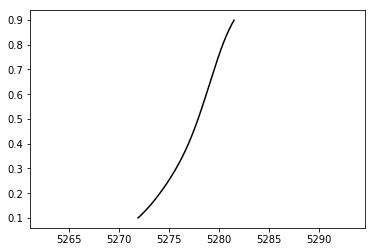

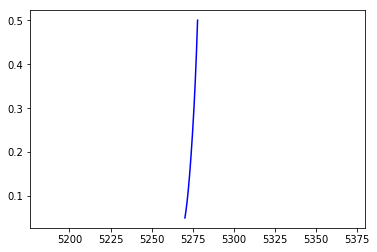

In [7]:
z = {"HE0119-0118":0.054341}#"HE0253-1641":0.031588,"HE2302-0857":0.046860}

#z_remaining = {"HE2128-0221":0.05248,"HE1248-1356":0.01465}

broad2= {'HE0119-0118':True}#,'HE0253-1641':True,'HE2302-0857':True}

objs = z.keys()

for obj in objs:
    algorithm_script(obj,z[obj],broad2[obj])
     
     #from the central pixel fit of Hb_br/ OIII_br , multiply this ratio with broad OIII luminosity to get H-beta luminosity 

In [ ]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692 #,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143,"HE0253-1641":0.031588
    ,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009,"HE0433-1028":0.035550
    ,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986,"HE1029-1831":0.040261
    ,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1330-1013":0.022145,"HE1353-1917":0.035021
    ,"HE1417-0909":0.044,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

#z_remaining = {"HE2128-0221":0.05248,"HE1248-1356":0.01465}

broad2= {'HE0021-1819':False,'HE0040-1105':False #,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False,'HE0253-1641':True
        ,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True,'HE0433-1028':True
        ,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False,'HE1029-1831':True
        ,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1330-1013':True,'HE1353-1917':True
        ,'HE1417-0909':False,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

objs = z.keys()

for obj in objs:
    algorithm_script(obj,z[obj],broad2[obj])